## Model wil Multiple Layers

In [1]:
#adding regularization
import numpy as np
import matplotlib.pyplot as plt
import scipy

from mnist import MNIST
import math
from numpy import linalg as LA
%matplotlib inline
mndata = MNIST('./data')
images_training, labels_training = mndata.load_training()
images_testing, labels_testing = mndata.load_testing()  
print(len(images_testing))
print(len(images_training))

10000
60000


In [2]:
total_training_X = np.matrix(images_training).T
total_training_Y = np.matrix(labels_training)
testing_X = np.matrix(images_testing).T
testing_Y = np.matrix(labels_testing)

In [3]:
# prepossing the data 
total_training_X = total_training_X/127.5-1
testing_X = testing_X/127.5-1



In [4]:
# shuffling the training data before splitting 
shuffle_index = list(np.random.permutation(total_training_X.shape[1]))
total_training_X = total_training_X[:,shuffle_index]
total_training_Y = total_training_Y[0,shuffle_index]


In [5]:
#for training set
training_Y = total_training_Y[:,:50000]
training_X = total_training_X[:,:50000] 

#for hold-out set 
holdout_Y = total_training_Y[:,-10000:]
holdout_X = total_training_X[:,-10000:]


In [6]:
#print(training_X.shape)
print(training_X.shape)
print(training_Y.shape)
print(testing_X.shape)
print(testing_Y.shape)


(784, 50000)
(1, 50000)
(784, 10000)
(1, 10000)


In [7]:
# minibatch and shuffling 
def random_mini_batches(X,Y,mini_batch_size=128):
    m = X.shape[1]
    mini_batches = []
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))
    num_complete_minibatches = math.floor(m/mini_batch_size) 
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:,k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    if m % mini_batch_size != 0:
        end = m - mini_batch_size * math.floor(m / mini_batch_size)
        mini_batch_X = shuffled_X[:,num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches * mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches
    

In [8]:
#minibatch test case 

mini_batches = random_mini_batches(training_X,training_Y, 128)

print("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
print("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

shape of the 1st mini_batch_X: (784, 128)
shape of the 2nd mini_batch_X: (784, 128)
shape of the 3rd mini_batch_X: (784, 128)
shape of the 1st mini_batch_Y: (1, 128)
shape of the 2nd mini_batch_Y: (1, 128)
shape of the 3rd mini_batch_Y: (1, 128)
mini batch sanity check: [[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1.]]


5(c) initializing the optimazed hidden layers parameters

In [9]:
# initializing the deep layer weight 
def initialize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims)            # number of layers in the network
#     a = random.normal(0, 0.1, (10, 10))
    for l in range(1, L):
        parameters['w' + str(l)] = np.random.normal(0,1/math.sqrt(layer_dims[l]),(layer_dims[l], layer_dims[l - 1]))*0.01
#         parameters['w' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        parameters['b' + str(l)] = np.random.rand(layer_dims[l], 1)*0.01
        
    return parameters

In [10]:
# checking the initializing value of weight 
parameters = initialize_parameters_deep([784,64,10,20])
#print("w3 = " + str(parameters["w3"].shape))
print("b3 = " + str(parameters["b3"].shape))
#print("w2 = " + str(parameters["w2"]))
#print("b2 = " + str(parameters["b2"]))

b3 = (20, 1)


#initializing the momentum velocity 
def initialize_velocity(parameters):
    L =int(len(parameters)/2)
    v = {}
    for l in range(L):
        v["dW"+str(l+1)] = np.zeros_like(parameters["w"+str(l+1)])
        v["db"+str(l+1)] = np.zeros_like(parameters["b"+str(l+1)])
        
    return v


5(c) initializing parameters with Nesterov momentum

# this is for Nvs momentum velocity 
def initialize_velocity(parameters):
    L =int(len(parameters)/2)
    v = {}
    v_prev = {}
    for l in range(L):
        v["dW"+str(l+1)] = np.zeros_like(parameters["w"+str(l+1)])
        v["db"+str(l+1)] = np.zeros_like(parameters["b"+str(l+1)])
        v_prev["dW"+str(l+1)] = np.zeros_like(parameters["w"+str(l+1)])
        v_prev["db"+str(l+1)] = np.zeros_like(parameters["b"+str(l+1)])
    
        
    return v,v_prev



In [11]:
# define a sigmoid function 
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    cache = (z)
    return s,cache


In [12]:
# define a sigmoid function 
def sigmoid1(z):
    s = 1/(1+np.exp(-z))
    return s

In [13]:
def tanh(x):
    cache = (x)
    return np.tanh(x),cache


In [14]:
def tanh1(x):
    cache = (x)
    return np.tanh(x)



5(c) implement relu 

In [15]:
def relu(x):
    cache = (x)
    return np.multiply(x , (x > 0)),cache

In [16]:
def softmax(a):
    a-=np.max(a,axis=0) #stabilize
    sum_a=np.sum(np.exp(a),axis=0)
    y_k= np.exp(a)/sum_a
    cache = (y_k)
    return y_k,cache

In [17]:
# linear forward method 
def linear_forward(A,W,b):
    Z =np.dot(W,A)+b
    cache = (A,W,b)
    return Z,cache

In [18]:
# linear activation forward method 
def linear_activation_forward(A_prev,w,b,activation):
    if activation =="sigmoid":
        Z, linear_cache = linear_forward(A_prev,w,b)
        A, activation_cache = sigmoid(Z)
    elif activation =="relu":
        Z, linear_cache = linear_forward(A_prev,w,b)
        A, activation_cache = relu(Z)
    elif activation =="tanh":
        Z, linear_cache = linear_forward(A_prev,w,b)
        A, activation_cache = tanh(Z)
    elif activation =="softmax":
        Z, linear_cache = linear_forward(A_prev,w,b)
        A, activation_cache = softmax(Z)
    
    cache = (linear_cache,activation_cache)
    return A, cache

In [19]:
# L-model forward for the purpose of doubling the hidden layer, here we assign L-1 sigmoid and output for sigmoid
def L_model_forward(X, parameters):   
    caches = []
    A = X
    L = int(len(parameters)/2)                        # number of layers in the neural network
    # Implement [LINEAR -> sigmoid]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, 
                                             parameters['w' + str(l)], 
                                             parameters['b' + str(l)], 
                                             activation='relu')
        caches.append(cache)
    
    # Implement LINEAR -> Softmax. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, 
                                          parameters['w' + str(L)], 
                                          parameters['b' + str(L)], 
                                          activation='softmax')
    caches.append(cache)
             
    return AL, caches


In [20]:
def build_mask(y):
    mask = np.zeros((10,y.shape[1]))
    mask[y,range(y.shape[1])] =1
    return mask

In [21]:
def sigmoid_backward(dA,activation_cache):
    z = activation_cache
    gradient =np.multiply(sigmoid1(z),(1. - sigmoid1(z)))
    dz = np.multiply(dA,gradient)
    return dz

In [22]:
def relu_backward(dA,activation_cache):
    z = activation_cache
    gradient = 1. * (z > 0)
    dz = np.multiply(dA,gradient)
    return dz 

In [23]:
#tanh
def tanh_backward(dA,activation_cache):
    z = activation_cache
    gradient = 1-np.multiply(tanh1(z),tanh1(z))
    dz = np.multiply(dA,gradient)
    return dz 



In [24]:
def softmax_backward(Y,activation_cache):
    Y_k  = activation_cache
    mask = build_mask(Y)
    dz = Y_k - mask
    return dz

In [25]:
# Computing the cost; here we use softmax! and crossentropy to compute the cost
def compute_cost(AL,y):
   # mask = build_mask(y)
    cost = -np.sum(np.log(AL[y,range(y.shape[1])]))/y.shape[1]/10
   # cost = np.squeeze(cost)
    return cost


In [26]:
# calculating the prediction accuracy
def predict(parameters, X,Y):
    y_k,caches = L_model_forward(X, parameters)
    y_pred = y_k.argmax(axis=0)
    count =0
    for i in range(X.shape[1]):
        if y_pred[0,i] == Y[0,i]:
            count = count+1
    acc = count/X.shape[1]
    
  # correct = [(m==n) for (m,n) in zip(y_pred,y)]
  # acc = sum(correct) * 1.0 / len(correct)
    return acc

In [27]:
# implementing backpropagation : linear backward
def linear_backward(dz,cache):
    A_prev,w,b = cache
    m = A_prev.shape[1]
    dw = np.dot(dz,cache[0].T)/m
    db = np.sum(dz,axis=1)/m
    dA_prev = np.dot(cache[1].T,dz)
    return dA_prev, dw, db

In [28]:
# implementing backpropagation : linear_activation backward containing linear backward
def linear_activation_backward(dA,cache,activation):  #Y is for updating the output value 
    linear_cache, activation_cache = cache
    if activation =="sigmoid":
        dz = sigmoid_backward(dA,activation_cache)
    elif activation =="relu":
        dz = relu_backward(dA,activation_cache)
    elif activation =="tanh":
        dz = tanh_backward(dA,activation_cache)
    dA_prev, dw , db = linear_backward(dz,linear_cache)
    return dA_prev,dw,db

In [29]:
def softmax_output_backward(Y,cache):
    linear_cache, activation_cache = cache
    dz = softmax_backward(Y,activation_cache)
    dA_prev, dw , db = linear_backward(dz,linear_cache)
    return dA_prev,dw,db

In [30]:
# GRADED FUNCTION: L_model_backward
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    
    # Lth layer (Softmax-> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    ### START CODE HERE ### (approx. 2 lines)
    current_cache = caches[-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = softmax_output_backward(Y,current_cache) 
    dA = grads["dA" + str(L)]
    
    for l in reversed(range(L-1)):        
        # Inputs: "grads["dA" + str(l + 2)], caches". Outputs: "grads["dA" + str(l + 1)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dA,current_cache,activation="relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

In [31]:
def update_parameters(parameters, grads, learning_rate): 
    L = int(len(parameters)/2)  # number of layers in the neural network
    for l in range(L):
        parameters["w" + str(l + 1)] = parameters["w" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
        
    return parameters

# update parameters with momentum
def update_parameters_with_momentum(parameters,grads,alpha,learning_rate,v):
    L = int(len(parameters)/2)
    for l in range(L):
        v["dW"+str(l+1)] = -alpha*v["dW"+str(l+1)]+learning_rate * grads["dW" + str(l + 1)]
        v["db"+str(l+1)] = -alpha*v["db"+str(l+1)]+learning_rate * grads["db" + str(l + 1)]
        #updating the parameters
        parameters["w"+str(l+1)] = parameters["w"+str(l+1)]- v["dW"+str(l+1)]
        parameters["b"+str(l+1)] = parameters["b"+str(l+1)]- v["db"+str(l+1)]
    return parameters,v

# Update parameters with Nesterov momentum   Notation from cse231n
def update_parameters_with_Nesterov_momentum(parameters,grads,alpha,learning_rate,v,v_prev):
    L = int(len(parameters)/2)
    for l in range(L):
        v_prev["dW"+str(l+1)] = v["dW"+str(l+1)]
        v_prev["db"+str(l+1)] = v["db"+str(l+1)]
        v["dW"+str(l+1)] = alpha*v["dW"+str(l+1)]-learning_rate * grads["dW" + str(l + 1)]
        v["db"+str(l+1)] = alpha*v["db"+str(l+1)]-learning_rate * grads["db" + str(l + 1)]
        #updating the parameters
        parameters["w"+str(l+1)] += -alpha*v_prev["dW"+str(l+1)] +(1+alpha)*v["dW"+str(l+1)]
        parameters["b"+str(l+1)] += -alpha*v_prev["db"+str(l+1)] +(1+alpha)*v["db"+str(l+1)]
        
    return parameters,v


    
#     v_prev = v # back this up
#     v = mu * v - learning_rate * dx # velocity update stays the same
#     x += -mu * v_prev + (1 + mu) * v # position update changes form

In [34]:
#minibatch 
def training_minibatch(X_training,Y_training,X_testing,Y_testing,num_epochs,learning_rate_0):
    accuracies_training = []
    accuracies_testing = []
    parameters = initialize_parameters_deep([784,10])
    for epoch in range(num_epochs):
        #num_minibatches = int(m/minibatch_size)
        mini_batches = random_mini_batches(X_training,Y_training, 4)
        for j in range(len(mini_batches)):
            AL_training_minibatch,caches_training_minibatch= L_model_forward(mini_batches[j][0],parameters)   
            #  
            if j == len(mini_batches)-1:
                AL_training,caches_training= L_model_forward(X_training,parameters) 
                #cost_training = compute_cost(AL_training,mini_batches[j][1])# costing for the entire training set ?
                accuracy_training = predict(parameters, X_training,Y_training)
                accuracy_testing = predict(parameters, X_testing,Y_testing)
                print(accuracy_testing)
                accuracies_training.append(1-accuracy_training)
                accuracies_testing.append(1-accuracy_testing) 
            #backward and updating
            grads = L_model_backward(AL_training_minibatch, mini_batches[j][1], caches_training_minibatch)   
            parameters = update_parameters(parameters, grads, learning_rate_0)
        # early stopping        
        print(epoch)
        
    return accuracies_training,accuracies_testing




5(a and b) Doubling the number of units in hidden layer and add one more layer  

In [35]:

accuracies_training,accuracies_testing=training_minibatch(training_X,training_Y,testing_X,testing_Y,50,0.01)

0.9134
0
0.9085
1
0.9153
2
0.8864
3
0.9152
4
0.912
5
0.8986
6
0.9042
7
0.9045
8
0.8834
9
0.9056
10
0.9193
11
0.9155
12
0.917
13
0.8933
14
0.8986
15
0.9108
16
0.9121
17
0.9101
18
0.9051
19
0.9128
20
0.9167
21
0.9148
22
0.9093
23
0.8992
24
0.9065
25
0.9159
26
0.8982
27
0.9087
28
0.9176
29
0.9155
30
0.883
31
0.9115
32
0.9134
33
0.9114
34
0.9087
35
0.9081
36
0.8977
37
0.9159
38
0.9163
39
0.9006
40
0.9175
41
0.9129
42
0.9154
43
0.9047
44
0.9133
45
0.9181
46
0.9155
47
0.9163
48
0.9169
49


In [38]:
accuracies_training[0]=1
accuracies_testing[0]=1

In [39]:
print(accuracies_training[-4],accuracies_testing[-4])

0.07206000000000001 0.08189999999999997


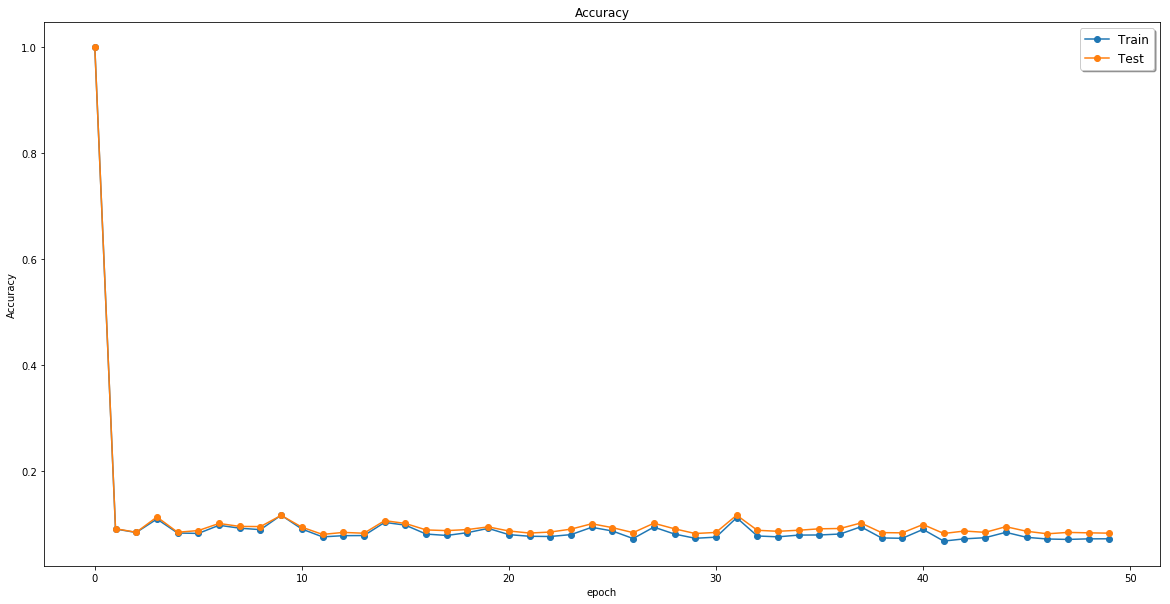

In [40]:
## Plot of the accuracy over training for the training, validation and test sets
plt.figure(figsize=(20,10))
plt.plot(range(len(accuracies_training)), accuracies_training, label='Train',marker='o')
plt.plot(range(len(accuracies_testing)), accuracies_testing, label='Test',marker='o')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(shadow=True, prop={'size': 12})
plt.title("Accuracy")
plt.show()